# EEG Databases Perprocessing

In [65]:
import os
import sklearn as sk
import torch
import numpy as np
import sys
import scipy.io as sio
from scipy.signal import resample
from tqdm.notebook import tqdm, trange
import warnings
import pickle
from scipy.signal import butter, filtfilt, sosfilt, sosfreqz
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

In [2]:
### For preprocessing
config = {
    "dataset_name": "deap",
    "databases_root_directory": r"E:/Databases/DEAP/data_preprocessed_python",
    "databases_out_directory": r"E:/Databases/DataPre/DEAP/",
    "downsampling_rate": 128,
    "channels_to_use": ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4'],
    "baseline_removal_window": 3,
    "cutoff_frequencies": [4,40],
    "seconds_to_use": 60,
    "downsampling_rate": 128,
    "window_size": 2,
    "window_overlap": 0,

}

In [10]:
class SignalProcessor:
    def __init__(self, fs=128):
        self.fs = fs

    def plot_frequency_spectrum(self, signal, fs=None, title='Frequency Spectrum'):
        """
        计算并绘制一维数组的频谱图。
        参数：
        signal (ndarray): 输入的一维数组。
        fs (int): 采样频率。
        返回：
        None
        """
        if fs is None:
            fs = self.fs
        # 计算傅里叶变换
        spectrum = np.fft.fft(signal)
        # 获取频率分量
        freqs = np.fft.fftfreq(len(signal), 1/fs)
        # 只取前半部分频率，因为频谱是对称的
        freqs = freqs[:len(freqs)//2]
        spectrum = np.abs(spectrum[:len(spectrum)//2])
        
        # 绘制频谱图
        plt.figure(figsize=(10, 6))
        plt.plot(freqs, spectrum)
        plt.title(title)
        plt.X_cp_cp_cp_cp_cplabel('Frequency (Hz)')
        plt.ylabel('Amplitude')
        plt.show()

        return freqs, spectrum

    def highpass_filter(self, signal, fs=None, cutoff=4, order=5):
        """
        对信号进行高通滤波。
        参数：
        signal (ndarray): 输入信号。
        cutoff (float): 截止频率。
        fs (int): 采样频率。
        order (int): 滤波器阶数。
        返回：
        ndarray: 高通滤波后的信号。
        """
        if fs is None:
            fs = self.fs
        nyquist = 0.5 * fs  # 计算奈奎斯特频率
        normal_cutoff = cutoff / nyquist  # 将截止频率归一化到[0, 1]之间
        b, a = butter(order, normal_cutoff, btype='high', analog=False)  # 设计高通Butterworth滤波器
        filtered_signal = filtfilt(b, a, signal)  # 使用filtfilt函数应用滤波器，避免相位失真
        return filtered_signal  # 返回滤波后的信号
    
    def lowpass_filter(self, signal, fs=None, cutoff=40, order=5):
        """
        对信号进行低通滤波。
        参数：
        signal (ndarray): 输入信号。
        cutoff (float): 截止频率。
        fs (int): 采样频率。
        order (int): 滤波器阶数。
        返回：
        ndarray: 低通滤波后的信号。
        """
        if fs is None:
            fs = self.fs
        nyquist = 0.5 * fs  # 计算奈奎斯特频率
        normal_cutoff = cutoff / nyquist  # 将截止频率归一化到[0, 1]之间
        b, a = butter(order, normal_cutoff, btype='low', analog=False)  # 设计低通Butterworth滤波器
        filtered_signal = filtfilt(b, a, signal)  # 使用filtfilt函数应用滤波器，避免相位失真
        return filtered_signal  # 返回滤波后的信号
    
    def bandpass_filter(self, signal, fs=None, lowcut=40, highcut=4, order=5):
        """
        对信号进行带通滤波。
        参数：
        signal (ndarray): 输入信号。
        lowcut (float): 低截止频率。
        highcut (float): 高截止频率。
        fs (int): 采样频率。
        order (int): 滤波器阶数。
        返回：
        ndarray: 带通滤波后的信号。
        """
        if fs is None:
            fs = self.fs
        nyquist = 0.5 * fs  # 计算奈奎斯特频率
        low = lowcut / nyquist  # 将低截止频率归一化到[0, 1]之间
        high = highcut / nyquist  # 将高截止频率归一化到[0, 1]之间
        b, a = butter(order, [low, high], btype='band')  # 设计带通Butterworth滤波器
        filtered_signal = filtfilt(b, a, signal)  # 使用filtfilt函数应用滤波器，避免相位失真
        return filtered_signal  # 返回滤波后的信号
    
    def notch_filter(self, signal, fs=None, cutoff=50, quality_factor=30):
        """
        对信号进行陷波滤波。
        参数：
        signal (ndarray): 输入信号。
        cutoff (float): 陷波频率。
        fs (int): 采样频率。
        quality_factor (float): 品质因数。
        返回：
        ndarray: 陷波滤波后的信号。
        """
        if fs is None:
            fs = self.fs
        nyquist = 0.5 * fs  # 计算奈奎斯特频率
        normal_cutoff = cutoff / nyquist  # 将陷波频率归一化到[0, 1]之间
        b, a = butter(2, [normal_cutoff - normal_cutoff / quality_factor, 
                        normal_cutoff + normal_cutoff / quality_factor], btype='bandstop')  # 设计带阻Butterworth滤波器
        filtered_signal = filtfilt(b, a, signal)  # 使用filtfilt函数应用滤波器，避免相位失真
        return filtered_signal  # 返回滤波后的信号
    
    def baseline_adjustments(self, signal):
        """
        基线调整
        参数：
        signal (ndarray): 输入信号。
        返回：
        ndarray: 调整后的信号。
        """
        base_line = signal.sum(0) / len(signal)
        signal = signal - base_line
        return signal
    
    def plot_signal_and_spectrum(self, signal, fs=None, suptitle='Signal and Spectrum'):
        """
        绘制信号和频谱图。
        
        参数：
        signal (ndarray): 输入的一维数组。
        fs (int): 采样频率。如果未提供，使用默认的 self.fs。
        suptitle (str): 图的总标题。
        
        返回：
        None
        """
        if fs is None:
            fs = self.fs

        # 计算傅里叶变换
        spectrum = np.fft.fft(signal)
        # 获取频率分量
        freqs = np.fft.fftfreq(len(signal), 1/fs)
        # 只取前半部分频率，因为频谱是对称的
        freqs = freqs[:len(freqs)//2]
        spectrum = np.abs(spectrum[:len(spectrum)//2])
        # 创建图形
        fig, axs = plt.subplots(1, 2, figsize=(14, 5))
        # 绘制信号
        axs[0].plot(signal)
        axs[0].set_title('Signal')
        axs[0].set_xlabel('Time')
        axs[0].set_ylabel('Amplitude')
        # 绘制频谱图
        axs[1].plot(freqs, spectrum)
        axs[1].set_title('Spectrum')
        axs[1].set_xlabel('Frequency (Hz)')
        axs[1].set_ylabel('Amplitude')
        # 添加总标题
        plt.suptitle(suptitle)
        # 调整布局
        plt.tight_layout(rect=[0, 0, 1, 0.96])  # 调整布局以确保标题不重叠
        plt.show()

sp = SignalProcessor()


In [114]:
class DatabasesPreprocessing(SignalProcessor):
    def __init__(self, fs=128):
        super().__init__(fs=fs)
        
        self.progress_bar = True
        self.sampling_rate = fs
        self.resampling_rate = fs
        self.channel_names = ['FP1', 'AF3', 'F3', 'F7', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO3', 'O1', 'OZ', 'PZ', 'FP2', 'AF4', 'FZ', 'F4', 'F8', 'FC6', 'FC2', 'CZ', 'C4', 'T8', 'CP6', 'CP2', 'P4', 'P8', 'PO4', 'O2']
        self.channels_to_use = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']
        self.window_size = 2
        self.window_overlap = 0


    def load_deap_data(self, data_path, rm_baseline=True):
        """
        加载DEAP数据集
        参数:
        data_path (str): 存储DEAP数据集的目录路径
        rm_baseline (bool): 是否移除前3s休息时的基线数据
        返回: 
        x_data, y_labels, subjects, trials, sessions = load_deap_data(data_path=data_path)
        tuple: 包含所有被试的EEG和其他生理信号数据，以及对应的情绪标签数据。
            x_data_32 (ndarray): 移除基线前形状为 (1280, 32, 8064) 的EEG数据。 移除基线后形状为 (1280, 32, 7680) 的EEG数据。
            y_data (ndarray): 形状为 (1280, 4) 的情绪标签数据。
        """
        # 获取目录中所有以.dat结尾的文件名
        files = [f for f in os.listdir(data_path) if f.endswith('.dat')]
        # 初始化存储所有数据和标签的列表
        raw_data = []  # 形状为 (num_subjects, num_trials, num_channels, num_samples)
        raw_labels = []  # 形状为 (num_subjects, num_trials, num_labels)
        subjects = []  # 存储每个试验的受试者编号
        trials = []  # 存储每个受试者的每次试验编号
        sessions = []  # 存储每个试验的会话编号
        # 是否显示进度条
        if self.progress_bar:
            files_iter = tqdm(files, desc="Loading DEAP data")
        else:
            files_iter = files
        # 遍历每个文件
        for file in files_iter:
            # 获取每个文件的完整路径
            file_path = os.path.join(data_path, file)
            # 打开并读取文件中的数据
            with open(file_path, 'rb') as f:
                # 使用latin1编码读取文件
                data = pickle.load(f, encoding='latin1')
                # 提取EEG和其他生理信号数据，并添加到 raw_data 列表中
                raw_data.append(data['data'])
                # 提取情绪标签数据，并添加到 raw_labels 列表中
                raw_labels.append(data['labels'])
                # # 添加受试者和试验信息
                subject_id = int(file[1:3])  # 提取受试者编号
                subjects.extend([subject_id] * 40)  # 每个受试者有 40 次试验
                trials.extend(range(1, 41))  # 每个受试者的试验编号从 1 到 40
                sessions.extend([1] * 40)  # 假设每个受试者只有一个会话
        # 将 raw_data 的形状从 (32, 40, 40, 8064) 改为 (1280, 40, 8064)
        x_data = np.array(raw_data).reshape(32*40, 40, 8064)
        # 选择前 32 个通道并去除前3s准备时间变为 (1280, 32, 7680)
        if rm_baseline:
            x_data_32 = x_data[:, :32, 3*128:]
        # 将 raw_labels 的形状从 (32, 40, 4) 改为 (1280, 4)
        y_labels = np.array(raw_labels).reshape(32*40, 4)
        # 将结果转换为NumPy数组并返回
        return np.array(x_data_32), np.array(y_labels), np.array(subjects), np.array(trials), np.array(sessions)
    
    def deap_preprocessing(self, X):
        # 复制输入信号，以保护原始数据
        X_cp = np.copy(X)
        if self.progress_bar:
            ep_id = trange(X_cp.shape[0], desc='Baseline adjustments and filter')
        else:
            ep_id = range(X_cp.shape[0])
        for experiment_id in ep_id:
            for channel_id in range(X_cp.shape[1]):
                # 基线调整
                X_cp[experiment_id, channel_id, :] = self.baseline_adjustments(signal=X_cp[experiment_id, channel_id, :])
                # 滤波
                X_cp[experiment_id, channel_id, :] = self.highpass_filter(signal=X_cp[experiment_id, channel_id, :], cutoff=4)
                X_cp[experiment_id, channel_id, :] = self.lowpass_filter(signal=X_cp[experiment_id, channel_id, :], cutoff=40)
        
        # 重采样
        X_cp = self.resampling(X=X_cp, sampling_rate=self.sampling_rate, resampling_rate=self.resampling_rate)
        # 选择合适的通道
        X_cp = self.select_channels(X=X_cp)
        

        return X_cp
    
    def resampling(self, X, sampling_rate, resampling_rate):
        """
        对信号进行重采样。
        参数：
        X (ndarray): 输入信号，形状为 (num_subjects, num_trials, num_samples)。
        sampling_rate (int): 原始采样率。
        resampling_rate (int): 目标采样率。
        返回：
        ndarray: 重采样后的信号。
        """
        # 复制输入信号，以保护原始数据
        X_cp = np.copy(X)
        # 检查是否需要重采样（目标采样率不为零且不同于原始采样率）
        if not(resampling_rate == 0) and not(resampling_rate == sampling_rate):
            # 计算重采样后的新长度
            new_length = int(X_cp.shape[2] / sampling_rate * resampling_rate)
            # 初始化重采样后的数组，形状为 (num_subjects, num_trials, new_length)
            X_resampled = np.zeros((X_cp.shape[0], X_cp.shape[1], new_length))
            # 判断是否需要显示进度条
            if self.progress_bar:
                ep_id = trange(X_cp.shape[0], desc='Downsampling')
            else:
                ep_id = range(X_cp.shape[0])
            # 遍历每个实验
            for experiment_id in ep_id:
                # 遍历每个通道
                for channel_id in range(X_cp.shape[1]):
                    # 对每个通道的数据进行重采样
                    X_resampled[experiment_id, channel_id, :] = resample(X_cp[experiment_id, channel_id, :], new_length)
            # 更新复制的数据为重采样后的数据
            X_cp = X_resampled
        # 返回重采样后的信号
        return X_cp
    
    def select_channels(self, X):
        """
        选择特定的通道。
        
        参数：
        X (ndarray): 输入信号，形状为 (num_subjects, num_channels, num_samples)。
        
        返回：
        ndarray: 选择通道后的信号，形状为 (num_subjects, len(self.channels_to_use), num_samples)。
        """
        # 复制输入信号，以保护原始数据
        X_cp = np.copy(X)
        # 初始化通道索引列表
        channel_index_list = list()
        # 查找需要使用的通道索引
        for i in range(len(self.channels_to_use)):
            # 如果通道在实际通道名称列表中，添加其索引到通道索引列表中
            if self.channels_to_use[i] in self.channel_names:
                channel_index_list.append(self.channel_names.index(self.channels_to_use[i]))
            else:
                # 如果通道不在实际通道名称列表中，发出警告
                warnings.warn(' Channel ' + self.channels_to_use[i] + ' could not be found in the list of actual channels')
        # 初始化选择通道后的数组，形状为 (num_subjects, len(self.channels_to_use), num_samples)
        X_selected_channels = np.zeros((X_cp.shape[0], len(self.channels_to_use), X_cp.shape[2]))
        # 判断是否需要显示进度条
        if self.progress_bar:
            channel_index_list_en = tqdm(enumerate(channel_index_list), desc="Select channels")
        else:
            channel_index_list_en = enumerate(channel_index_list)
        # 遍历每个通道及其索引，将对应的通道数据复制到选择后的数组中
        for channel, channel_index in channel_index_list_en:
            X_selected_channels[:, channel, :] = X_cp[:, channel_index, :]
        # 更新复制的数据为选择通道后的数据
        X_cp = X_selected_channels
        # 返回选择通道后的信号
        return X_cp
    
    def deap_label_conversion(self, X, y, subjects, trials, sessions, convert_labels_to_nnp=True, plot_en=True):
        X_cp = np.copy(X)
        y_cp = np.copy(y)
        # 计算每个窗口的点数和每个窗口的重叠点数
        num_points_per_window = dp.window_size * dp.resampling_rate
        num_points_overlap = dp.window_overlap * dp.resampling_rate
        # 计算窗口滑动的步长
        stride = num_points_per_window - num_points_overlap
        # 初始化起始和结束索引列表
        start_index = [0]
        end_index = [num_points_per_window]
        # 初始化每个实验的窗口数
        num_windows_per_exp = 1
        # 计算每个实验的窗口数以及相应的起始和结束索引
        while(end_index[-1] + stride <= X_cp.shape[2]):
            num_windows_per_exp += 1
            start_index.append(start_index[-1] + stride)
            end_index.append(end_index[-1] + stride)
        # 初始化切割后的数据数组
        X_cut = np.zeros((num_windows_per_exp * X_cp.shape[0], X_cp.shape[1], num_points_per_window))
        y_cut = np.zeros((num_windows_per_exp * X_cp.shape[0], 4))
        subjects_cut = np.zeros(num_windows_per_exp * X_cp.shape[0])
        trials_cut = np.zeros(num_windows_per_exp * X_cp.shape[0])
        sessions_cut = np.zeros(num_windows_per_exp * X_cp.shape[0])
        # 遍历每个实验
        for exp_id in trange(X_cp.shape[0]):
            # 遍历每个窗口
            for window_id in range(len(start_index)):
                # 根据窗口的起始和结束索引切割数据
                X_cut[exp_id * num_windows_per_exp + window_id, :, :] = X_cp[exp_id, :, start_index[window_id]:end_index[window_id]]
                # 复制标签、会话、受试者和试验信息
                y_cut[exp_id * num_windows_per_exp + window_id, :] = y_cp[exp_id, :]
                subjects_cut[exp_id * num_windows_per_exp + window_id] = subjects[exp_id]
                trials_cut[exp_id * num_windows_per_exp + window_id] = trials[exp_id]
                sessions_cut[exp_id * num_windows_per_exp + window_id] = sessions[exp_id]
        # 更新原始数据为切割后的数据
        X_cp = X_cut
        y_cp = y_cut
        subjects = subjects_cut
        trials = trials_cut
        sessions = sessions_cut
        # 创建 MinMaxScaler 对象，用于将数据缩放到 [-1, 1] 范围
        scaler = MinMaxScaler(feature_range=(-1,1))
        # 将情绪价度(愉快度)标签缩放到 [-1, 1] 范围
        valence = scaler.fit_transform(y_cp[:,0].reshape(-1,1))
        # 将唤醒度标签缩放到 [-1, 1] 范围
        arousal = scaler.fit_transform(y_cp[:,1].reshape(-1,1))
        # 将缩放后的愉快度和唤醒度标签按列连接成一个新的数据数组
        datapoints = np.concatenate((valence, arousal), axis=1)
        # 使用 KMeans 对数据进行聚类，指定聚类数量为 4，随机种子为 7
        kmeans = KMeans(n_clusters=4, random_state=7).fit(datapoints)
        # 对聚类中心点按与四个角（右下角、左下角、左上角、右上角）的距离进行排序
        # 并分别对应悲伤 (sad)、恐惧 (fear)、中性 (neutral)、快乐 (happy) 标签
        sad_label, fear_label, neutral_label, happy_label = self.sort_centeroids(centeroids=kmeans.cluster_centers_)
        if plot_en:
            # 绘制愉快度（Valence）和唤醒度（Arousal）的散点图，并使用 KMeans 聚类的标签进行着色
            plt.scatter(valence, arousal, c=kmeans.labels_, edgecolors='none')
            plt.xlabel('Valence')  # 设置 x 轴标签
            plt.ylabel('Arousal')  # 设置 y 轴标签
            plt.title('DEAP - NNP Label via K-Means')  # 设置图表标题
            plt.show()  # 显示图表

            # 统计每个情绪类别的数据点数量，并打印结果
            print('#Fear: %i - #Sad: %i - #Neutral: %i - Happy: %i'
                % (np.count_nonzero(kmeans.labels_ == fear_label),  # 统计恐惧类标签的数据点数量
                    np.count_nonzero(kmeans.labels_ == sad_label),   # 统计悲伤类标签的数据点数量
                    np.count_nonzero(kmeans.labels_ == neutral_label),  # 统计中性类标签的数据点数量
                    np.count_nonzero(kmeans.labels_ == happy_label)))  # 统计快乐类标签的数据点数量
        # 找到每个情绪类别对应的数据点索引
        idx_sad = np.where(kmeans.labels_ == sad_label)  # 找到悲伤类标签的数据点索引
        idx_fear = np.where(kmeans.labels_ == fear_label)  # 找到恐惧类标签的数据点索引
        idx_neutral = np.where(kmeans.labels_ == neutral_label)  # 找到中性类标签的数据点索引
        idx_happy = np.where(kmeans.labels_ == happy_label)  # 找到快乐类标签的数据点索引
        # 初始化新的标签数组，形状与 y_cp 相同
        Y_nnp = np.zeros(y_cp.shape[0],)
        # 根据索引设置新的标签值
        Y_nnp[idx_sad] = -1  # 将悲伤类标签设为 -1
        Y_nnp[idx_fear] = -1  # 将恐惧类标签设为 -1
        Y_nnp[idx_neutral] = 0  # 将中性类标签设为 0
        Y_nnp[idx_happy] = 1  # 将快乐类标签设为 1
        # 如果需要转换，则将 y_cp 更新为新的标签
        if convert_labels_to_nnp:
            y_cp = Y_nnp

        return X_cp, y_cp

    def sort_centeroids(self, centeroids):
        """
        计算给定中心点到四个角（右下角、左下角、左上角、右上角）的距离，
        并返回按以下顺序排列的索引：
        - 最靠近右下角的点的索引
        - 最靠近左下角的点的索引
        - 最靠近左上角的点的索引
        - 最靠近右上角的点的索引
        参数：
        centeroids (ndarray): 中心点数组，形状为 (num_points, 2)，每行表示一个点的坐标 (x, y)。
        返回：
        tuple: 包含四个整数的元组，表示最靠近右下角、左下角、左上角和右上角的点的索引。
        """
        # 初始化距离数组
        distance_br = np.zeros(centeroids.shape[0])  # 到右下角的距离
        distance_bl = np.zeros(centeroids.shape[0])  # 到左下角的距离
        distance_tl = np.zeros(centeroids.shape[0])  # 到左上角的距离
        distance_tr = np.zeros(centeroids.shape[0])  # 到右上角的距离
        # 计算每个中心点到四个角的距离
        for i in range(centeroids.shape[0]):
            distance_br[i] = abs((1 - centeroids[i, 0])**2 + (-1 - centeroids[i, 1])**2)
            distance_bl[i] = abs((-1 - centeroids[i, 0])**2 + (-1 - centeroids[i, 1])**2)
            distance_tl[i] = abs((-1 - centeroids[i, 0])**2 + (1 - centeroids[i, 1])**2)
            distance_tr[i] = abs((1 - centeroids[i, 0])**2 + (1 - centeroids[i, 1])**2)
        # 找到距离四个角最近的点的索引
        br_idx = np.argmin(distance_br)  # 最靠近右下角的点的索引
        bl_idx = np.argmin(distance_bl)  # 最靠近左下角的点的索引
        tl_idx = np.argmin(distance_tl)  # 最靠近左上角的点的索引
        tr_idx = np.argmin(distance_tr)  # 最靠近右上角的点的索引
        # 返回索引
        return br_idx, bl_idx, tl_idx, tr_idx
    
        
    
        
dp = DatabasesPreprocessing()


## 加载数据

In [111]:
deap_data_path = r'E:/Databases/DEAP/data_preprocessed_python'  # 定义数据路径
x_data, y_labels, subjects, trials, sessions = dp.load_deap_data(data_path=deap_data_path)  # 读取数据
X = x_data
y = y_labels


Loading DEAP data:   0%|          | 0/32 [00:00<?, ?it/s]

## 数据处理
- 基线调整
- 滤波
- 重采样
- 通道选择

In [115]:
X = dp.deap_preprocessing(X=X)

Baseline adjustments and filter:   0%|          | 0/1280 [00:00<?, ?it/s]

Select channels: 0it [00:00, ?it/s]

In [117]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"session shape: {subjects.shape}")
print(f"session shape: {trials.shape}")
print(f"session shape: {sessions.shape}")
print(f"subject: {np.unique(subjects)}")
print(f"trial: {np.unique(trials)}")
print(f"session: {np.unique(sessions)}")

X shape: (1280, 14, 7680)
y shape: (1280, 4)
session shape: (1280,)
session shape: (1280,)
session shape: (1280,)
subject: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32]
trial: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]
session: [1]


  0%|          | 0/1280 [00:00<?, ?it/s]

g:\ToolSoftware\anaconda3\envs\pt231py38\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


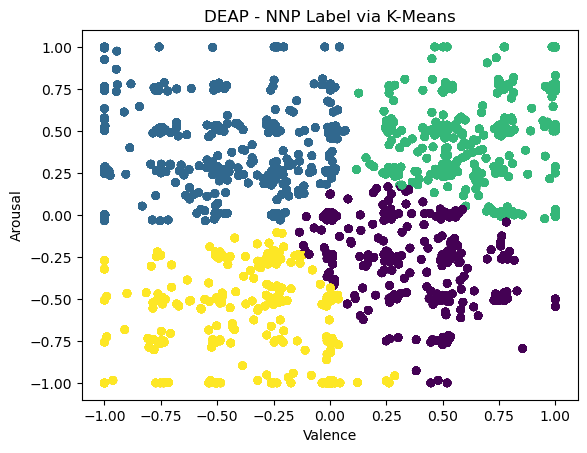

#Fear: 8310 - #Sad: 9270 - #Neutral: 10200 - Happy: 10620
X: (38400, 14, 256)
y: (38400,)


In [80]:
X_cp = np.copy(X)
y_cp = np.copy(y)
X_cp, y_cp = dp.deap_label_conversion(X=X_cp, y=y_cp, subjects=subjects, trials=trials, sessions=sessions)
# 打印 X_cp 和 y_cp 的形状
print(f"X: {X_cp.shape}")
print(f"y: {y_cp.shape}")

In [118]:
X_cp = np.copy(X)
y_cp = np.copy(y)
# 计算每个窗口的点数和每个窗口的重叠点数
num_points_per_window = dp.window_size * dp.resampling_rate
num_points_overlap = dp.window_overlap * dp.resampling_rate
# 计算窗口滑动的步长
stride = num_points_per_window - num_points_overlap
# 初始化起始和结束索引列表
start_index = [0]
end_index = [num_points_per_window]
# 初始化每个实验的窗口数
num_windows_per_exp = 1
# 计算每个实验的窗口数以及相应的起始和结束索引
while(end_index[-1] + stride <= X_cp.shape[2]):
    num_windows_per_exp += 1
    start_index.append(start_index[-1] + stride)
    end_index.append(end_index[-1] + stride)
# 初始化切割后的数据数组
X_cut = np.zeros((num_windows_per_exp * X_cp.shape[0], X_cp.shape[1], num_points_per_window))
y_cut = np.zeros((num_windows_per_exp * X_cp.shape[0], 4))
session_cut = np.zeros(num_windows_per_exp * X_cp.shape[0])
subject_cut = np.zeros(num_windows_per_exp * X_cp.shape[0])
trial_cut = np.zeros(num_windows_per_exp * X_cp.shape[0])
# 遍历每个实验
for exp_id in trange(X_cp.shape[0]):
    # 遍历每个窗口
    for window_id in range(len(start_index)):
        # 根据窗口的起始和结束索引切割数据
        X_cut[exp_id * num_windows_per_exp + window_id, :, :] = X_cp[exp_id, :, start_index[window_id]:end_index[window_id]]
        # 复制标签、会话、受试者和试验信息
        y_cut[exp_id * num_windows_per_exp + window_id, :] = y_cp[exp_id, :]
        session_cut[exp_id * num_windows_per_exp + window_id] = sessions[exp_id]
        subject_cut[exp_id * num_windows_per_exp + window_id] = subjects[exp_id]
        trial_cut[exp_id * num_windows_per_exp + window_id] = trials[exp_id]
# 更新原始数据为切割后的数据
# X_cp = X_cut
# y_cp = y_cut
session = session_cut
subject = subject_cut
trial = trial_cut
print(f"X_cut shape: {X_cut.shape}")
print(f"y_cut shape: {y_cut.shape}")
print(f"session shape: {np.array(session).shape}")
print(f"subject shape: {np.array(subject).shape}")
print(f"trial shape: {np.array(trial).shape}")


  0%|          | 0/1280 [00:00<?, ?it/s]

X_cut shape: (38400, 14, 256)
y_cut shape: (38400, 4)
session shape: (38400,)
subject shape: (38400,)
trial shape: (38400,)


In [119]:
import numpy as np

def sort_centeroids(centeroids):
    """
    计算给定中心点到四个角（右下角、左下角、左上角、右上角）的距离，
    并返回按以下顺序排列的索引：
    - 最靠近右下角的点的索引
    - 最靠近左下角的点的索引
    - 最靠近左上角的点的索引
    - 最靠近右上角的点的索引
    参数：
    centeroids (ndarray): 中心点数组，形状为 (num_points, 2)，每行表示一个点的坐标 (x, y)。
    返回：
    tuple: 包含四个整数的元组，表示最靠近右下角、左下角、左上角和右上角的点的索引。
    """
    # 初始化距离数组
    distance_br = np.zeros(centeroids.shape[0])  # 到右下角的距离
    distance_bl = np.zeros(centeroids.shape[0])  # 到左下角的距离
    distance_tl = np.zeros(centeroids.shape[0])  # 到左上角的距离
    distance_tr = np.zeros(centeroids.shape[0])  # 到右上角的距离
    # 计算每个中心点到四个角的距离
    for i in range(centeroids.shape[0]):
        distance_br[i] = abs((1 - centeroids[i, 0])**2 + (-1 - centeroids[i, 1])**2)
        distance_bl[i] = abs((-1 - centeroids[i, 0])**2 + (-1 - centeroids[i, 1])**2)
        distance_tl[i] = abs((-1 - centeroids[i, 0])**2 + (1 - centeroids[i, 1])**2)
        distance_tr[i] = abs((1 - centeroids[i, 0])**2 + (1 - centeroids[i, 1])**2)
    # 找到距离四个角最近的点的索引
    br_idx = np.argmin(distance_br)  # 最靠近右下角的点的索引
    bl_idx = np.argmin(distance_bl)  # 最靠近左下角的点的索引
    tl_idx = np.argmin(distance_tl)  # 最靠近左上角的点的索引
    tr_idx = np.argmin(distance_tr)  # 最靠近右上角的点的索引
    # 返回索引
    return br_idx, bl_idx, tl_idx, tr_idx



In [128]:
y_cpp = np.copy(y_cut)
print(f"y_cpp: {y_cpp[1,:]}")
# 创建 MinMaxScaler 对象，用于将数据缩放到 [-1, 1] 范围
scaler = MinMaxScaler(feature_range=(-1,1))
# 将愉快度标签缩放到 [-1, 1] 范围
valence = scaler.fit_transform(y_cp[:,0].reshape(-1,1))
print(f"valence: {valence[1,:]}")
# 将唤醒度标签缩放到 [-1, 1] 范围
arousal = scaler.fit_transform(y_cp[:,1].reshape(-1,1))
# 将缩放后的愉快度和唤醒度标签按列连接成一个新的数据数组
datapoints = np.concatenate((valence, arousal), axis=1)
print(f"datapoints shape: {datapoints.shape}")
# 使用 KMeans 对数据进行聚类，指定聚类数量为 4，随机种子为 7
kmeans = KMeans(n_clusters=4, random_state=7).fit(datapoints)
# 对聚类中心点按与四个角（右下角、左下角、左上角、右上角）的距离进行排序
# 并分别对应悲伤 (sad)、恐惧 (fear)、中性 (neutral)、快乐 (happy) 标签
sad_label, fear_label, neutral_label, happy_label = sort_centeroids(kmeans.cluster_centers_)
print(f"val: {sad_label}, {fear_label}, {neutral_label}, {happy_label}")


y_cpp: [7.71 7.6  6.9  7.83]
valence: [0.775]
datapoints shape: (1280, 2)
val: 0, 3, 1, 2


g:\ToolSoftware\anaconda3\envs\pt231py38\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


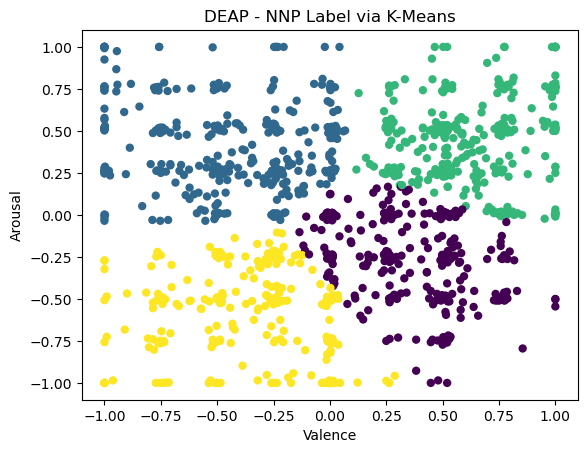

#Fear: 277 - #Sad: 309 - #Neutral: 340 - Happy: 354


In [126]:
# 绘制愉快度（Valence）和唤醒度（Arousal）的散点图，并使用 KMeans 聚类的标签进行着色
plt.scatter(valence, arousal, c=kmeans.labels_, edgecolors='none')
plt.xlabel('Valence')  # 设置 x 轴标签
plt.ylabel('Arousal')  # 设置 y 轴标签
plt.title('DEAP - NNP Label via K-Means')  # 设置图表标题
plt.show()  # 显示图表

# 统计每个情绪类别的数据点数量，并打印结果
print('#Fear: %i - #Sad: %i - #Neutral: %i - Happy: %i'
      % (np.count_nonzero(kmeans.labels_ == fear_label),  # 统计恐惧类标签的数据点数量
         np.count_nonzero(kmeans.labels_ == sad_label),   # 统计悲伤类标签的数据点数量
         np.count_nonzero(kmeans.labels_ == neutral_label),  # 统计中性类标签的数据点数量
         np.count_nonzero(kmeans.labels_ == happy_label)))  # 统计快乐类标签的数据点数量

In [135]:
# 找到每个情绪类别对应的数据点索引
idx_sad = np.where(kmeans.labels_ == sad_label)  # 找到悲伤类标签的数据点索引
idx_fear = np.where(kmeans.labels_ == fear_label)  # 找到恐惧类标签的数据点索引
idx_neutral = np.where(kmeans.labels_ == neutral_label)  # 找到中性类标签的数据点索引
idx_happy = np.where(kmeans.labels_ == happy_label)  # 找到快乐类标签的数据点索引
# 初始化新的标签数组，形状与 y_cp 相同
Y_nnp = np.zeros(y_cp.shape[0],)
print(f"Y_nnp: {Y_nnp.shape}")
# 根据索引设置新的标签值
Y_nnp[idx_sad] = -1  # 将悲伤类标签设为 -1
Y_nnp[idx_fear] = -1  # 将恐惧类标签设为 -1
Y_nnp[idx_neutral] = 0  # 将中性类标签设为 0
Y_nnp[idx_happy] = 1  # 将快乐类标签设为 1
print(f"Y_nnp modify: {Y_nnp.shape}")
# # 是否将原始标签转换为新的 NNP 标签
# convert_labels_to_nnp = True
# # 如果需要转换，则将 y_cp 更新为新的标签
# if convert_labels_to_nnp:
#     y_cpp = Y_nnp
# 打印 X_cp 和 y_cpp 的形状
print(f"X: {X_cp.shape}")
print(f"y: {y_cp.shape}")
print(f"idx_sad: {np.array(idx_sad).shape}")
print(f"idx_sad: {np.array(idx_fear).shape}")
print(f"idx_sad: {np.array(idx_neutral).shape}")
print(f"idx_sad: {np.array(idx_happy).shape}")



Y_nnp: (1280,)
Y_nnp modify: (1280,)
X: (1280, 14, 7680)
y: (1280, 4)
idx_sad: (1, 309)
idx_sad: (1, 277)
idx_sad: (1, 340)
idx_sad: (1, 354)
